In [1]:
import numpy as np
import torch
import helper
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from torchvision import datasets, transforms

# define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ])

# download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# batch size above means each load will return 64 images
# the images are a tensor of (64, 1, 28, 28)
#  so basically, 64 images, one color channel(gray scale), a 28 x 28 pixel size

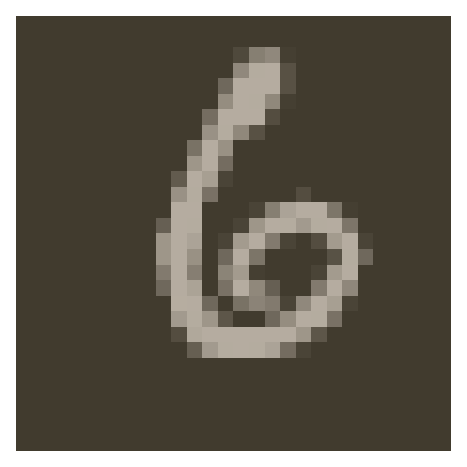

In [3]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Exercise: flatten the batch of images and build a multilayer with 784 input units, 256 hidden units, and 10 output units using random tensors for weights and biases. Using the sigmoid activation for the hidden layer, leave the output layer without an activation

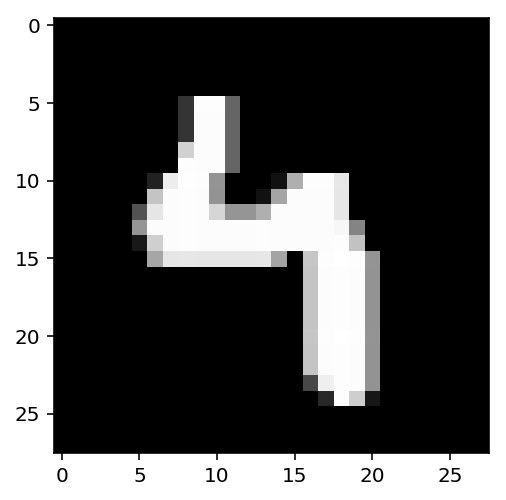

In [5]:
# show example of image
plt.imshow(images[5].numpy().squeeze(), cmap='Greys_r');

In [6]:
images.shape[0]

64

In [7]:
# data stored in variable images

# features is the flattened tensors as calculated below
# needed to flatten image, so resize matrix from 28 x 28 to 784
# images.shape[0] = 64
features = images.view(images.shape[0], 784)

# size of each layer in neural network
n_input = 784
n_hidden = 256
n_output = 10

# weights for input to hidden layer
W1 = torch.randn(n_input, n_hidden)

# weights for hidden layer to output
W2 = torch.randn(n_hidden, n_output)

# bias terms for hidden and output
B1 = torch.randn(n_hidden)
B2 = torch.randn(n_output)

In [8]:
def activation(x):
    return 1 / (1 + torch.exp(-x))

In [9]:
# calculate output for hidden layer
h = activation(torch.mm(features, W1) + B1)
print(h.shape)

torch.Size([64, 256])


In [14]:
# calculate output layer
out = (torch.mm(h, W2) + B2) # will use softmax instead of activation(sigmoid)
print(out.shape)

torch.Size([64, 10])


Now, we want to make a probability distribution that shows the likeliness that an image fits into a particular class (here, the class is the number displayed). We can do this using the softmax function because it's able to normalize the values of the input between 0 and 1 to get a probability distribution that sums to 1.

Exercise: Implement a softmax function that performs the softmax calculation and returns the probability distribution for each example in the batch.

In [16]:
def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1).view(64, 1)
    # dim=1 takes the sum of columns, dim=0 of rows
    # in place of .view(64, 1) may do .view(-1, 1) and torch will determine appropriate digits as 64
    
probabilities = softmax(out)

print(probabilities.shape)

print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


PyTorch has a module that makes building networks much simpler, nn. This is how to do the above problem with this module:

In [12]:
from torch import nn

In [17]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256) # (input, output)
        # output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # define sigmoid activiation and softmax output
        self.Sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # pass input tensor through each operation
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [19]:
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (Sigmoid): Sigmoid()
  (softmax): Softmax()
)

In [20]:
# a more concise way to define a network using the functional module

import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 256)
        # output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x